# KAZ env  

Using cpu device


/Users/angeleramauge/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.18GB > 1.84GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.194    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1720     |
|    time_elapsed     | 0        |
|    total_timesteps  | 848      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00599  |
|    n_updates        | 46       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1778     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1584     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00188  |
|    n_updates        | 92       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rat

/Users/angeleramauge/anaconda3/lib/python3.11/site-packages/supersuit/vector/sb3_vector_wrapper.py:52: UserWarning: PettingZoo environments do not take the `render(mode)` argument, to change rendering mode, re-initialize the environment using the `render_mode` argument.
  warnings.warn(
/Users/angeleramauge/anaconda3/lib/python3.11/site-packages/pettingzoo/butterfly/knights_archers_zombies/knights_archers_zombies.py:799: UserWarning: WARN: You are calling render method without specifying any render mode.
  gymnasium.logger.warn(


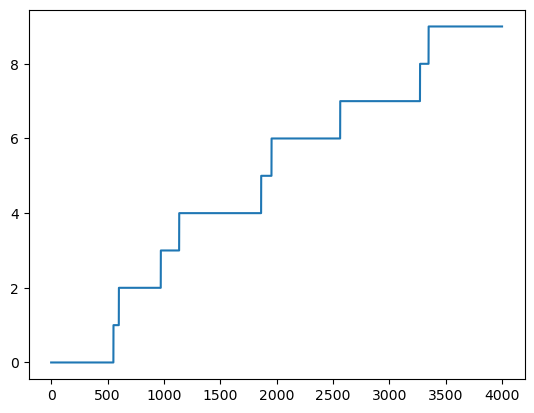

In [18]:
from pettingzoo.butterfly import knights_archers_zombies_v10
from pettingzoo.utils.conversions import aec_to_parallel
import supersuit as ss
from stable_baselines3 import DQN
import numpy as np
import matplotlib.pyplot as plt

# Charger l'environnement PettingZoo AEC (par défaut)
aec_env = knights_archers_zombies_v10.env()

# Convertir l'environnement AEC en ParallelEnv
parallel_env = aec_to_parallel(aec_env)

# Appliquer le wrapper 'black_death_v3' pour gérer les agents inactifs
parallel_env = ss.black_death_v3(parallel_env)

# Utiliser SuperSuit pour convertir l'environnement en un environnement Gym compatible
gym_env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
gym_env = ss.concat_vec_envs_v1(gym_env, 1, base_class='stable_baselines3')

# Initialiser le modèle DQN
model = DQN('MlpPolicy', gym_env, verbose=1)

# Entraîner l'agent
model.learn(total_timesteps=10000)

# Sauvegarder le modèle
model.save("dqn_knights_archers_zombies")

# Charger le modèle pour l'utiliser ou l'évaluer
model = DQN.load("dqn_knights_archers_zombies")

# Évaluer le modèle
env = knights_archers_zombies_v10.parallel_env()
env = ss.black_death_v3(env)
env = ss.pettingzoo_env_to_vec_env_v1(env)
env = ss.concat_vec_envs_v1(env, 1, base_class='stable_baselines3')
model.set_env(env)

obs = env.reset()
rewards = []
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done.any():
        obs = env.reset()

# Afficher les récompenses
plt.plot(np.cumsum(rewards))
plt.show()

# # Make a video of the trained model
# env = knights_archers_zombies_v10.parallel_env()
# env = ss.black_death_v3(env)
# env = ss.pettingzoo_env_to_vec_env_v1(env)
# env = ss.concat_vec_envs_v1(env, 1, base_class='stable_baselines3')
# model.set_env(env)
# ss.record_video(env, model, "dqn_knights_archers_zombies.mp4", video_length=1000, fps=10)

# # Afficher la vidéo


In [ ]:
from pettingzoo.butterfly import knights_archers_zombies_v10
from pettingzoo.utils.conversions import aec_to_parallel
import supersuit as ss
from stable_baselines3 import DQN
import numpy as np
import matplotlib.pyplot as plt

# Charger l'environnement PettingZoo AEC (par défaut)
aec_env = knights_archers_zombies_v10.env()

# Convertir l'environnement AEC en ParallelEnv
parallel_env = aec_to_parallel(aec_env)

# Appliquer le wrapper 'black_death_v3' pour gérer les agents inactifs
parallel_env = ss.black_death_v3(parallel_env)

# Utiliser SuperSuit pour convertir l'environnement en un environnement Gym compatible
gym_env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
gym_env = ss.concat_vec_envs_v1(gym_env, 1, base_class='stable_baselines3')

# Initialiser les modèles DQN pour chaque agent
num_agents = gym_env.num_envs  # Récupérer le nombre d'agents à partir de l'environnement
models = [DQN('MlpPolicy', gym_env, verbose=1) for _ in range(num_agents)]

# Entraîner les agents
timesteps = 1000
for episode in range(10):  # Nombre d'épisodes d'entraînement
    print(f"Episode {episode + 1}")
    obs = gym_env.reset()
    done = np.array([False] * num_agents)

    for step in range(timesteps):
        actions = np.array([models[i].predict(obs[i])[0] for i in range(num_agents)])  # Prédire les actions pour chaque agent
        obs, rewards_batch, done, _ = gym_env.step(actions)  # Appliquer les actions dans l'environnement
        
        for i in range(num_agents):
            models[i].learn(total_timesteps=1)  # Mettre à jour chaque agent après chaque étape
        
        if done.any():
            obs = gym_env.reset()

# Sauvegarder les modèles
for i in range(num_agents):
    models[i].save(f"dqn_agent_{i + 1}_knights_archers_zombies")

# Évaluer les modèles
obs = gym_env.reset()
rewards = [[] for _ in range(num_agents)]  # Liste pour stocker les récompenses de chaque agent
done = np.array([False] * num_agents)

for _ in range(1000):
    actions = np.array([models[i].predict(obs[i])[0] for i in range(num_agents)])  # Prédire les actions pour chaque agent
    obs, rewards_batch, done, _ = gym_env.step(actions)  # Appliquer les actions dans l'environnement
    for i in range(num_agents):
        rewards[i].append(rewards_batch[i])  # Stocker les récompenses pour chaque agent
    if done.any():
        obs = gym_env.reset()

# Afficher les récompenses cumulées pour chaque agent
for i in range(num_agents):
    plt.plot(np.cumsum(rewards[i]), label=f'Agent {i + 1}')
plt.xlabel('Étapes')
plt.ylabel('Récompense cumulée')
plt.legend()
plt.title('Récompenses cumulées par agent')
plt.show()


Using cpu device
Using cpu device
Using cpu device
Using cpu device
Episode 1


/Users/angeleramauge/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.18GB > 2.16GB
  warnings.warn(
/Users/angeleramauge/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.18GB > 2.17GB
  warnings.warn(


Episode 2
Episode 3
Episode 4
